<a href="https://colab.research.google.com/github/yashlal/Deepfake-Microbiomes/blob/main/decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA device selected!
Using 1 GPU


Epoch 0: Loss 0.11124835636589411
Epoch 1: Loss 1.2379896192221707
Epoch 2: Loss 0.5796309702585367
Epoch 3: Loss 0.5712294420681743
Epoch 4: Loss 0.4186884744011219
Epoch 5: Loss 0.37976831726753935
Epoch 6: Loss 0.33079914456388315
Epoch 7: Loss 0.2618642657454767
Epoch 8: Loss 0.23047178694865142
Epoch 9: Loss 0.21015927498387713
Epoch 10: Loss 0.18351477662282561
Epoch 11: Loss 0.1745199589708707
Epoch 12: Loss 0.15405587458936515
Epoch 13: Loss 0.14363469907882948
Epoch 14: Loss 0.11349217426388045
Epoch 15: Loss 0.10780293932817894
Epoch 16: Loss 0.10180288941512469
Epoch 17: Loss 0.08390737260772524
Epoch 18: Loss 0.08327482048286917
Epoch 19: Loss 0.06227214113081968
Epoch 20: Loss 0.06711125515952306
Epoch 21: Loss 0.042718210292558886
Epoch 22: Loss 0.03859701287580293
Epoch 23: Loss 0.048481411778787585
Epoch 24: Loss 0.03705821530121636
Epoch 25: Loss 0.03744469817637144
Epoch 26: Loss 0.026224976075469468
Epoch 27: Loss 0.05324133736471562
Epoch 28: Loss 0.0458615264234674

Epoch 0: Loss 0.0352551872966856
Epoch 1: Loss 0.03645936005631546
Epoch 2: Loss 0.033524135867168334
Epoch 3: Loss 0.033928539997087837
Epoch 4: Loss 0.03566706501591524
Epoch 5: Loss 0.0360411694695728
Epoch 6: Loss 0.03716153632625684
Epoch 7: Loss 0.03605754139275879
Epoch 8: Loss 0.034895715106617826
Epoch 9: Loss 0.03448291977266875
Epoch 10: Loss 0.035130764104168
Epoch 11: Loss 0.035193000799473906
Epoch 12: Loss 0.03627158245853517
Epoch 13: Loss 0.0348400459193489
Epoch 14: Loss 0.035470974534730026
Epoch 15: Loss 0.035045532611154305
Epoch 16: Loss 0.03566153482909777
Epoch 17: Loss 0.035679112911798046
Epoch 18: Loss 0.03483910280082474
Epoch 19: Loss 0.03699281360206363
Epoch 20: Loss 0.03678027574907845
Epoch 21: Loss 0.03627511098953038
Epoch 22: Loss 0.0352852097400639
Epoch 23: Loss 0.03551248194669751
Epoch 24: Loss 0.03335386839976846



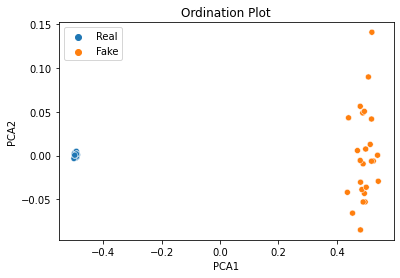

In [15]:
from newsolver import predict_community_fullnp
import numpy as np
import pandas as pd
import random as rd
from numba import njit
from numba.typed import List
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import time
from math import sqrt
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from modules import *
from scipy.stats import wasserstein_distance as WD
from sklearn.decomposition import PCA
import seaborn as sns

data = pd.read_excel('RealData.xlsx', index_col=0)
specs = data.columns.tolist()
trimmed_specs = []
typed_trimmed_specs = List()
pca = PCA(n_components=2)

for i in range(len(specs)):
    if data.iloc[:,i].astype(bool).sum() >= 85:
        trimmed_specs.append(specs[i])
        typed_trimmed_specs.append(specs[i])

def datagen():
    lm = generate_matrix(typed_trimmed_specs)
    cm = predict_community_fullnp(lm, trimmed_specs, verb=False)
    return get_LT(lm), cm

# select CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda:0':
    print('CUDA device selected!')
elif str(device) == 'cpu':
	print('CUDA device not available. CPU selected')

class MyNet(nn.Module):
    def __init__(self, hyperparam):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(231*461, hyperparam)
        self.fc2 = nn.Linear(hyperparam, 462)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_net(model, train_size):
    loss_values = []
    pbar2 = tqdm(range(train_size))
    pca_training_communities = []
    pbar2.set_description(f'Training Neural Net on {train_size} Epochs')
    for epoch in pbar2:
        optimizer.zero_grad()
        x, y = datagen()

        input = torch.FloatTensor(x).to(device)
        true_y = torch.from_numpy(y).float().to(device)
        output = model(input).to(device)
        loss = criterion(output, true_y).to(device)
        s = WD(y.tolist(), output.detach().tolist())
        print(f'Epoch {epoch}: Loss {s}')
        loss_values.append(s)
        loss.backward()
        optimizer.step()
        pca_training_communities.append(y.tolist())
        pca_training_communities.append(output.detach().tolist())
    pca.fit(pca_training_communities)
    return loss_values

def test_net(model, test_size):
    pca_testing_communities = []
    labels = []
    pbar3 = tqdm(range(test_size))
    pbar3.set_description(f'Testing Neural Net on {test_size} Epochs')
    for epoch in pbar3:
        x, y = datagen()
        input = torch.FloatTensor(x).to(device)
        true_y = torch.from_numpy(y).float().to(device)
        output = model(input).to(device)
        s = WD(y.tolist(), output.detach().tolist())
        print(f'Epoch {epoch}: Loss {s}')
        pca_testing_communities.append(y.tolist())
        labels.append('Real')
        pca_testing_communities.append(output.detach().tolist())
        labels.append('Fake')
    transformed_data = pca.fit_transform(pca_testing_communities)
    return transformed_data, labels

if __name__=='__main__':
    train_size, test_size, param, = 3000, 25, 2500
    path = 'model.pth'

    net = MyNet(param).to(device)

    #Multi GPU Support
    if torch.cuda.device_count() > 1:
        print(f'Using {torch.cuda.device_count()} GPUs')
        net = nn.DataParallel(net)
    elif torch.cuda.device_count() == 1:
        print(f'Using {torch.cuda.device_count()} GPU')

    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=1e-4)

    lv = train_net(net, train_size=train_size)
    transformed_data, labels = test_net(model=net, test_size=test_size)
    df = pd.DataFrame(transformed_data, columns=['PCA1', 'PCA2'])

    ax0 = sns.scatterplot(data=df, x='PCA1', y='PCA2', hue=labels)
    ax0.set(title='Ordination Plot', xlabel='PCA1', ylabel='PCA2')

    plt.savefig('Ordination Plot')
    plt.show()
